### Introduction
The main goal of this project is to use Doc2Vec to learn representations of entire texts of varying lengths. Doc2Vec is based on the paragraph vectors framework where instead of tokenizing text into words, n-grams or characters, we represent the entire paragraph as a vector.
Aftor learning the representations, we will feed the transformed text into a  classifier and perform sentiment analysis of Amazon product reviews.

### Data Preparation

In [12]:
#Importing Libraries

#Machine learning and deep learning
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#pre-processing of text
import string
import re
import json
import gzip
from urllib.request import urlopen

In [ ]:
#Unzipping data
!unzip amazon_review_mil.csv.zip
reviews_data = 'amazon_review_mil.csv'

In [5]:
#Loading into pandas dataframe
df = pd.read_csv(reviews_data)
df.columns = ['reviewerID','asin','helpful','reviewText','overall','summary','unixReviewTime','reviewTime','reviewerName','sentiment']
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewerName,sentiment
0,AH2L9G3DQHHAJ,0000000116,"[5, 5]",Interesting Grisham tale of a lawyer that take...,4.0,Show me the money!,1019865600,"04 27, 2002",chris,1
1,A2IIIDRK3PRRZY,0000000116,"[0, 0]",The thumbnail is a shirt. The product shown i...,1.0,Listing is all screwed up,1395619200,"03 24, 2014",Helene,-1
2,A1TADCM7YWPQ8M,0000000868,"[10, 10]",I'll be honest. I work for a large online reta...,4.0,Not a Bad Translation,1031702400,"09 11, 2002",Joel@AWS,1
3,AWGH7V0BDOJKB,0000013714,"[0, 0]",It had all the songs I wanted but I had ordere...,4.0,Not the large print,1383177600,"10 31, 2013",Barbara Marshall,1
4,A3UTQPQPM4TQO0,0000013714,"[0, 0]","We have many of the old, old issue. But the nu...",5.0,I was disappointed that you would only allow m...,1374883200,"07 27, 2013",betty burnett,1


In [6]:
#Checking class distribution
df.sentiment.value_counts()

 1    895395
-1    104605
Name: sentiment, dtype: int64

### Text Preprocessing
Main steps in preprocessing are removing stopwords, punctuations, digits etc.

In [34]:
#Cleaning the reviews' text
mystopwords = stop_words.ENGLISH_STOP_WORDS
def clean(reviews):
    def remove_stops_digits(doc):
        doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
        doc = " ".join([token for token in doc.split() if token not in stopwords])
        return doc
    return [remove_stops_digits(review) for review in reviews]


In [70]:
X = clean(df.reviewText[10000:19000])
y = df.sentiment[10000:19000]

In [71]:
# Splitting data into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)



In [72]:
#Learn doc2vec representations
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(X_train)]

model = Doc2Vec(vector_size=50, alpha=0.025, min_count=10, dm =1, epochs=30)
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")

Model Saved


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [74]:
#After learning vectors, infer vector for train & test data
model= Doc2Vec.load("d2v.model")
#infer in multiple steps to get a stable representation. 
train_vectors =  [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_train]
test_vectors = [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in X_test]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#Feed the trained vectors into any classifier to train for sentiment analysis. Here I use Logistic Regression
from sklearn.linear_model import LogisticRegression

myclass = LogisticRegression(class_weight="balanced") #because classes are not balanced. 
myclass.fit(train_vectors, y_train)

preds = myclass.predict(test_vectors)


In [85]:
#Function to plot confusion matrix
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    '''
    This function prints and plots the confusion matrix.
    
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

              precision    recall  f1-score   support

          -1       0.32      0.62      0.42       421
           1       0.89      0.70      0.78      1829

    accuracy                           0.68      2250
   macro avg       0.60      0.66      0.60      2250
weighted avg       0.78      0.68      0.71      2250



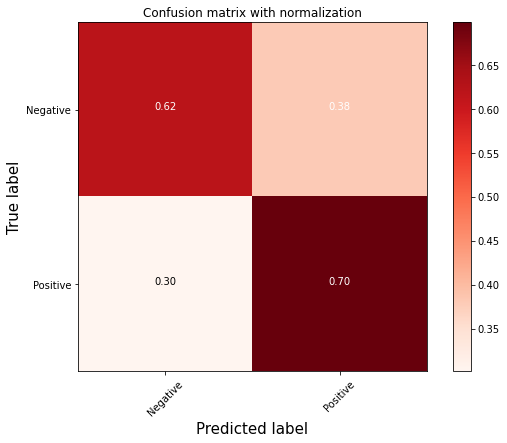

In [86]:
#Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds))
cnf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','Positive'],normalize=True,
                      title='Confusion matrix with normalization')
